In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt



In [ ]:
from google.colab import files
uploaded = files.upload()


Saving cleaned_dataset (1).csv to cleaned_dataset (1).csv


In [ ]:
import io
df = pd.read_csv(io.BytesIO(uploaded[list(uploaded.keys())[0]]))
df['text'] = df['text'].astype(str).str.lower()

In [ ]:
print(df.head(11))

                         text emoji
0                     on edge     😤
1      disrespectful behavior     😡
2           barely holding on     😤
3                whatever man     🙄
4                  that smile     😍
5                       phew!     😅
6            that was awkward     😅
7               dreamy moment     😍
8   why are people like this?     😡
9                    applause     👏
10       rolling on the floor     😂


In [ ]:
MAX_VOCAB = 8000
MAX_LEN = 20

tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text'])
X = pad_sequences(sequences, maxlen=MAX_LEN, padding='post')

In [ ]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['emoji'])
y_cat = to_categorical(y)

In [ ]:

X_temp, X_test, y_temp, y_test = train_test_split(X, y_cat, test_size=0.1, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)


In [ ]:
!wget -q http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

embedding_index = {}
with open("glove.6B.100d.txt", encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = vector

In [ ]:
EMBED_DIM = 100
embedding_matrix = np.zeros((MAX_VOCAB, EMBED_DIM))
for word, i in tokenizer.word_index.items():
    if i < MAX_VOCAB:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [ ]:
y_integers = np.argmax(y_cat, axis=1)
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_integers),
    y=y_integers
)
class_weights = dict(enumerate(weights))
print(class_weights)

{0: np.float64(1.0), 1: np.float64(1.0), 2: np.float64(1.0), 3: np.float64(1.0), 4: np.float64(1.0), 5: np.float64(1.0), 6: np.float64(1.0), 7: np.float64(1.0), 8: np.float64(1.0), 9: np.float64(1.0), 10: np.float64(1.0), 11: np.float64(1.0), 12: np.float64(1.0), 13: np.float64(1.0), 14: np.float64(1.0), 15: np.float64(1.0), 16: np.float64(1.0), 17: np.float64(1.0), 18: np.float64(1.0), 19: np.float64(1.0)}


In [ ]:
model = Sequential([
    Embedding(MAX_VOCAB, EMBED_DIM, weights=[embedding_matrix], input_length=MAX_LEN, trainable=False),
    Dropout(0.3),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(64)),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(y_cat.shape[1], activation='softmax')
])
model.compile(loss='categorical_crossentropy', optimizer=Adam(1e-4), metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=40, batch_size=32,
                    class_weight=class_weights, callbacks=[early_stop])


Epoch 1/40
113/113 ━━━━━━━━━━━━━━━━━━━━ 20s 83ms/step - accuracy: 0.0624 - loss: 2.9898 - val_accuracy: 0.0989 - val_loss: 2.9747
Epoch 2/40
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - accuracy: 0.0951 - loss: 2.9690 - val_accuracy: 0.1989 - val_loss: 2.9383
Epoch 3/40
113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 70ms/step - accuracy: 0.1322 - loss: 2.9195 - val_accuracy: 0.2033 - val_loss: 2.8094
Epoch 4/40
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - accuracy: 0.1846 - loss: 2.7572 - val_accuracy: 0.2422 - val_loss: 2.5548
Epoch 5/40
113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 73ms/step - accuracy: 0.1981 - loss: 2.5622 - val_accuracy: 0.2756 - val_loss: 2.3627
Epoch 6/40
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - accuracy: 0.2262 - loss: 2.4435 - val_accuracy: 0.3200 - val_loss: 2.2229
Epoch 7/40
113/113 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.2843 - loss: 2.3088 - val_accuracy: 0.3878 - val_loss: 2.0741
Epoch 8/40
113/113 ━━━━━━━━━━━━━━━━━━━━ 12s 69ms/step - accuracy: 0.3086 - loss: 2.2249 - val_a

In [ ]:

test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8810 - loss: 0.4143
Test Accuracy: 0.8860


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step


/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 128077 (\N{THUMBS UP SIGN}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 128079 (\N{CLAPPING HANDS SIGN}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 128548 (\N{FACE WITH LOOK OF TRIUMPH}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 128580 (\N{FACE WITH ROLLING EYES}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 129300 (\N{THINKING FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 129314 (\N{NAUSEATED FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/

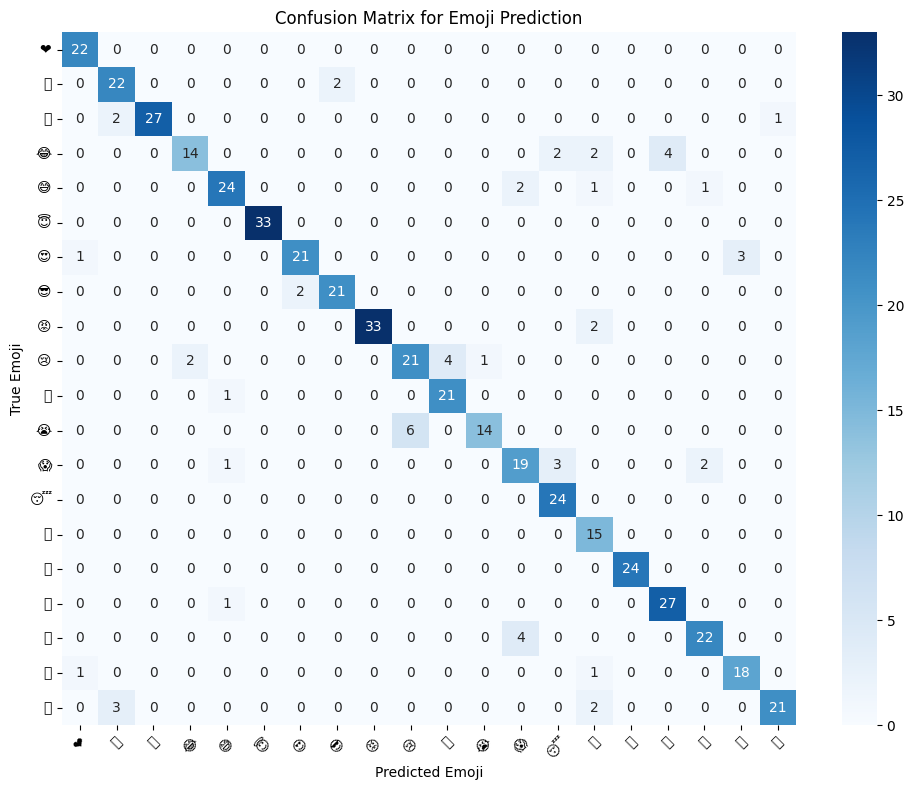

Classification Report:

              precision    recall  f1-score   support

          ❤️       0.92      1.00      0.96        22
           👍       0.81      0.92      0.86        24
           👏       1.00      0.90      0.95        30
           😂       0.88      0.64      0.74        22
           😅       0.89      0.86      0.87        28
           😇       1.00      1.00      1.00        33
           😍       0.91      0.84      0.88        25
           😎       0.91      0.91      0.91        23
           😡       1.00      0.94      0.97        35
           😢       0.78      0.75      0.76        28
           😤       0.84      0.95      0.89        22
           😭       0.93      0.70      0.80        20
           😱       0.76      0.76      0.76        25
           😴       0.83      1.00      0.91        24
           🙄       0.65      1.00      0.79        15
           🤔       1.00      1.00      1.00        24
           🤢       0.87      0.96      0.92        28
   

In [ ]:

y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test, axis=1)


labels = label_encoder.classes_


cm = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Emoji')
plt.ylabel('True Emoji')
plt.title('Confusion Matrix for Emoji Prediction')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


print("Classification Report:\n")
print(classification_report(y_true_classes, y_pred_classes, target_names=labels))


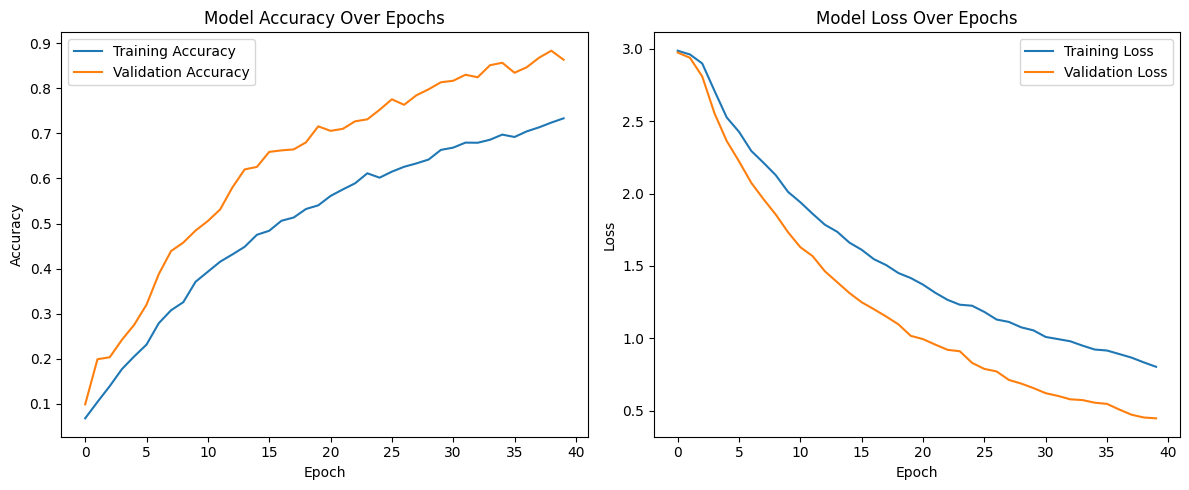

In [ ]:

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
def predict_emoji(text):
    seq = tokenizer.texts_to_sequences([text.lower()])
    padded = pad_sequences(seq, maxlen=MAX_LEN, padding='post')
    pred = model.predict(padded)[0]
    top3 = np.argsort(pred)[-3:][::-1]
    for i in top3:
        emoji = label_encoder.inverse_transform([i])[0]
        print(f"{emoji}: {pred[i]:.2f}")


In [ ]:
while True:
    user_input = input("Enter a phrase (or type 'exit'): ").strip()

    if not user_input:
        print("❗ Please enter something meaningful.\n")
        continue

    if user_input.lower() == 'exit':
        print("👋 Exiting prediction loop.")
        break

    print(f"Phrase: {user_input}")
    predict_emoji(user_input)
    print("-" * 40)

Enter a phrase (or type 'exit'): Happy birthday to you
Phrase: Happy birthday to you
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
❤️: 0.65
🥳: 0.19
😍: 0.11
----------------------------------------
Enter a phrase (or type 'exit'): congratulations
Phrase: congratulations
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
👏: 0.56
🥳: 0.34
😎: 0.06
----------------------------------------
Enter a phrase (or type 'exit'): i'm proud of you
Phrase: i'm proud of you
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
🥳: 0.83
😍: 0.04
👏: 0.04
----------------------------------------
Enter a phrase (or type 'exit'): get lost 
Phrase: get lost
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
😢: 0.22
😴: 0.22
😂: 0.18
----------------------------------------
Enter a phrase (or type 'exit'): oh my god!!
Phrase: oh my god!!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
🥰: 0.46
😍: 0.43
❤️: 0.06
----------------------------------------
Enter a phrase (or type 'exit'): Oh!
Phrase: Oh!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
🙄: 0.23
🥰: 0.20
🤢: 0.10
--------------